In [40]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [41]:
%run /home/datarian/git/master-thesis-code/notebooks/common_init.ipynb

Setup logging to file: out.log
Figure output directory saved in figure_output at /home/datarian/OneDrive/unine/Master_Thesis/ma-thesis-report/figures


In [42]:
%run /home/datarian/git/master-thesis-code/notebooks/learning_init.ipynb

Set plot_confusion_matrix and registered Rescaler()


In [43]:
%autoreload 2
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

# Load custom code
import kdd98.data_handler as dh
from kdd98.config import Config
import pathlib
import pickle

In [44]:
from collections import Counter
from imblearn.combine import SMOTETomek
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

In [45]:
from sklearn.preprocessing import StandardScaler, RobustScaler, PowerTransformer, FunctionTransformer
from sklearn.model_selection import ParameterGrid, GridSearchCV, RandomizedSearchCV, StratifiedShuffleSplit
from sklearn.metrics import confusion_matrix, make_scorer, log_loss, roc_auc_score, recall_score, precision_score, classification_report, roc_curve, auc
from sklearn.neural_network import MLPClassifier
from imblearn.pipeline import Pipeline

In [46]:
# Where to save the figures

CHAPTER_ID = "neural_net_mlp"
# Where to save the figures
IMAGES_PATH = pathlib.Path(figure_output/'learning')

pathlib.Path(IMAGES_PATH).mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension=["pdf", "png"], resolution=300):
    if tight_layout:
        plt.tight_layout()
    [plt.savefig(pathlib.Path(IMAGES_PATH, fig_id + "." + f), 
                 format=f,
                 dpi=resolution,
                 transparent=True,
                 bbox_inches='tight') for f in fig_extension]

In [47]:
with open(pathlib.Path(Config.get("df_store"), "X_train.pd.pkl"), "rb") as f:
    kdd98_learn_feat = pickle.load(f)
with open(pathlib.Path(Config.get("df_store"), "y_train.pd.pkl"), "rb") as f:
    kdd98_learn_targets = pickle.load(f)
with open(pathlib.Path(Config.get("df_store"), "X_test.pd.pkl"), "rb") as f:
    kdd98_test_feat = pickle.load(f)
with open(pathlib.Path(Config.get("df_store"), "y_test.pd.pkl"), "rb") as f:
    kdd98_test_targets = pickle.load(f)
with open(pathlib.Path(Config.get("df_store"), "X_train_all_relevant.pd.pkl"), "rb") as f:
    kdd98_learn_feat_all_relevant = pickle.load(f)
with open(pathlib.Path(Config.get("df_store"), "X_test_all_relevant.pd.pkl"), "rb") as f:
    kdd98_test_feat_all_relevant = pickle.load(f)
    
# Extracting the data and resetting target to [-1, 1]
X_train = kdd98_learn_feat.values
X_train_all_relevant = kdd98_learn_feat_all_relevant.values
y_train = kdd98_learn_targets.loc[:,"TARGET_B"].astype("int64").values
X_test = kdd98_test_feat.values
X_test_all_relevant = kdd98_test_feat_all_relevant.values
y_test = kdd98_test_targets.loc[:,"TARGET_B"].astype("int64").values

In [17]:
class_weight = len(y_train[y_train == 0])/sum(y_train)

In [18]:
ovs = RandomOverSampler(sampling_strategy="minority", random_state=Config.get("random_seed"))
X_resampled, y_resampled = ovs.fit_resample(X_train_all_relevant, y_train)
print(sorted(Counter(y_resampled).items()))

[(0, 72455), (1, 72455)]


# Neural Network

In [23]:
scaler = Rescaler(transformer="ftrans")
X_rescaled = scaler.fit_transform(X_resampled)
X_test_rescaled = scaler.transform(X_test_all_relevant)

In [20]:
mlp = MLPClassifier(solver="adam",
                    random_state=Config.get("random_seed"))

In [21]:
mlp.fit(X_rescaled,y_resampled)

/data/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=42, shuffle=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False)

In [24]:
y_predict = mlp.predict(X_test_rescaled)

In [25]:
print(pd.DataFrame(confusion_matrix(y_test, y_predict),
columns=['pred_neg', 'pred_pos'], index=['neg', 'pos']))

     pred_neg  pred_pos
neg     12896      5218
pos       587       382


Normalized confusion matrix
[[0.39422085 0.60577915]
 [0.28806448 0.71193552]]


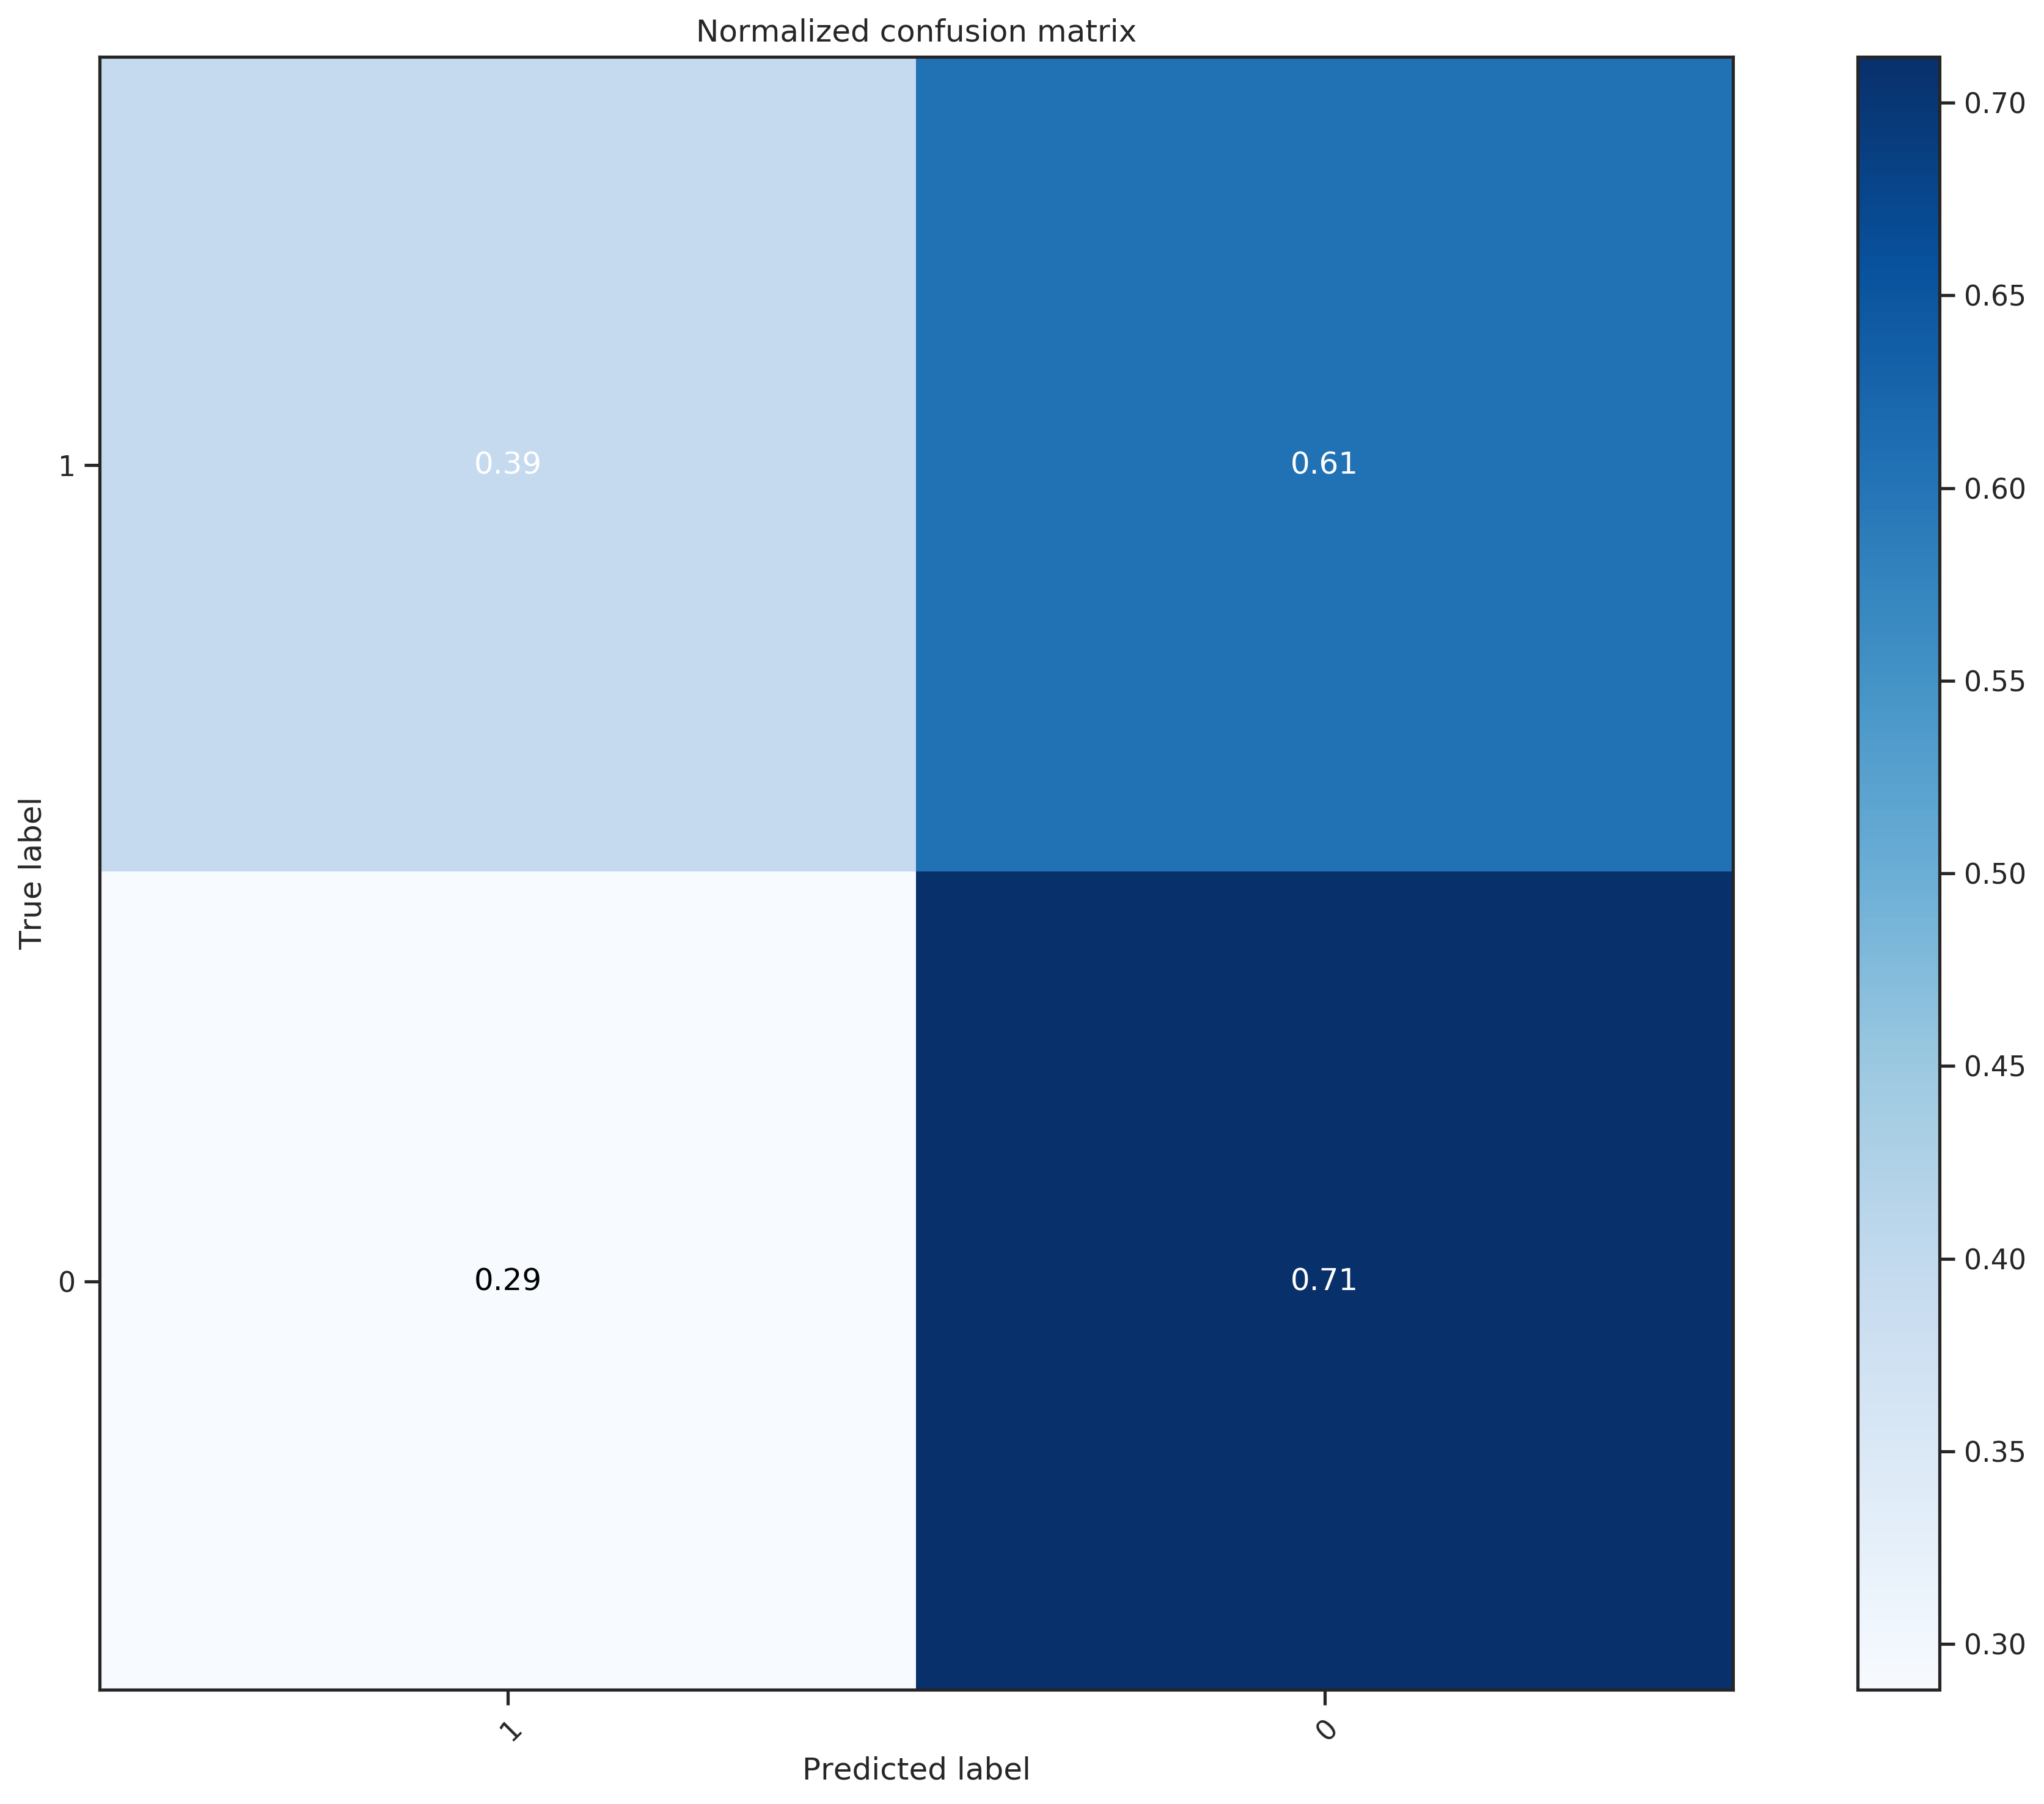

In [26]:
plot_confusion_matrix(y_test,y_predict, classes=[1,0], normalize=True)

In [33]:
scaler = Rescaler()

sampler = RandomOverSampler(sampling_strategy="minority", random_state=Config.get("random_seed"))

mlp = MLPClassifier(solver="adam",
                    random_state=Config.get("random_seed"))

mlp_pipeline = Pipeline([
    ("scaler", scaler),
    ("sampler", sampler),
    ("nnet", mlp)
])

In [35]:
param_grid = {
    "scaler__transformer": ["ftrans", "rtrans"],
    "sampler__ratio": [0.1,0.2, 0.5],
    "nnet__alpha": 10.0 ** -np.arange(1, 7)}

In [38]:
scoring = {"ROC": make_scorer(roc_auc_score),
           "logloss": make_scorer(log_loss, labels = [0,1]),
           "recall": make_scorer(recall_score)}

gs_mlp = GridSearchCV(
    mlp_pipeline,
    param_grid,
    scoring=scoring,
    n_jobs=-1,
    cv=5,
    refit="recall",
    verbose=3
)

In [39]:
gs_mlp.fit(X_train_all_relevant, y_train)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed: 25.8min


KeyboardInterrupt: 

In [ ]:
gs_mlp.best_estimator_.get_params

In [ ]:
y_predict = gs_mlp.best_estimator_.predict(X_test_all_relevant)

In [ ]:
plot_confusion_matrix(y_test, y_predict, classes=[0,1])

In [ ]:
import pickle
import pathlib
with open(pathlib.Path(Config.get("model_store"), "neuralnetwork_gridsearch.pkl"), "wb") as f:
    pickle.dump(gs_mlp, f)

In [ ]:
classifier = gs_mlp.best_estimator_

In [ ]:
del gs_mlp